# **LASSO Regression**

**Objective**: Solve the LASSO problem using the **ISTA**  
(Iterative Shrinkage-Thresholding Algorithm) method:

$$
\min_x \; \frac{1}{2} \, \|Ax - b\|_2^2 + \lambda \, \|x\|_1
$$

---

## 1. Setup and Libraries

We import essential libraries:
- `numpy` for linear algebra  
- `matplotlib` for basic plotting


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Uncomment if you use real datasets in CSV format:
# import pandas as pd

# For inline plots:
%matplotlib inline


## 2. LASSO Problem Formulation

We aim to solve the LASSO optimization problem:

**Objective function:**

  $f(x) = \frac{1}{2}\|Ax - b\|_2^2$,  
  $g(x) = \lambda \|x\|_1$

So the full problem becomes:

  $\min_x \; f(x) + g(x) = \frac{1}{2}\|Ax - b\|_2^2 + \lambda \|x\|_1$

---

### Gradient of $f(x)$:

  $\nabla f(x) = A^\top (Ax - b)$

---

### Proximity operator of $g(x) = \lambda \|x\|_1$:

  $\text{prox}_{\alpha \lambda \| \cdot \|_1}(v)_i = \text{sign}(v_i) \cdot \max(|v_i| - \alpha \lambda,\; 0)$

---

### ISTA update rule:

  $x^{k+1} = \text{prox}_{\alpha \lambda \| \cdot \|_1}\left(x^k - \alpha \nabla f(x^k)\right)$


In [2]:
np.random.seed(42)  # reproducibility

m, n = 200, 50  # m = samples, n = features
A = np.random.randn(m, n)

# True sparse vector
x_true = np.zeros(n)
num_nonzero = 5
selected_indices = np.random.choice(range(n), num_nonzero, replace=False)
x_true[selected_indices] = np.random.uniform(5, 10, size=num_nonzero)

# Generate b = A x_true + noise
b = A @ x_true + 0.1 * np.random.randn(m)

print("A shape:", A.shape)
print("b shape:", b.shape)
print("Number of nonzero elements in x_true:", np.count_nonzero(x_true))


A shape: (200, 50)
b shape: (200,)
Number of nonzero elements in x_true: 5


## 4. Basic Functions

In this section, we define the core mathematical components needed to solve the LASSO problem.

---

### 4.1 Gradient of the smooth part $f(x)$

The function $f(x) = \frac{1}{2} \|Ax - b\|_2^2$ is smooth and convex.

Its gradient is given by:  
  $\nabla f(x) = A^\top(Ax - b)$


In [3]:
def grad_f(A, b, x):
    """
    Gradient of f(x) = 0.5 * ||Ax - b||^2
    """
    return A.T @ (A @ x - b)


---

### 4.2 Proximal operator of $g(x) = \lambda \|x\|_1$

The $\ell_1$ norm is not differentiable, so we use its proximal operator, which is:

  $\text{prox}_{\alpha \lambda \|\cdot\|_1}(v)_i = \text{sign}(v_i) \cdot \max(|v_i| - \alpha \lambda,\; 0)$

This is known as the **soft-thresholding** operator.


In [4]:
def prox_l1(v, alpha_lambda):
    """
    Proximal operator for g(x) = lambda * ||x||_1.
    Implements soft-thresholding.
    
    Parameters:
      v : input vector
      alpha_lambda : step size * lambda
      
    Returns:
      Thresholded vector
    """
    return np.sign(v) * np.maximum(np.abs(v) - alpha_lambda, 0.0)


---

### 4.3 LASSO objective function 

To monitor convergence, we define the full LASSO objective function:

  $F(x) = \frac{1}{2}\|Ax - b\|_2^2 + \lambda \|x\|_1$


In [5]:
def lasso_objective(A, b, x, lambda_):
    """
    Computes the LASSO objective:
    F(x) = 0.5 * ||A x - b||^2 + lambda * ||x||_1
    """
    residual = A @ x - b
    return 0.5 * np.linalg.norm(residual)**2 + lambda_ * np.linalg.norm(x, 1)


## 5. ISTA Implementation

This section outlines the iterative routine for solving the LASSO problem using ISTA:

1. **Initialize** $x^0$ (e.g., a zero vector).  
2. **For each iteration**:
   - **Gradient step**:  
     $$
     z^k \;=\; x^k \;-\; \alpha \,\nabla f(x^k)
     $$
   - **Proximal step** (soft-thresholding):  
     $$
     x^{k+1} \;=\; \mathrm{prox}_{\alpha\,\lambda\,\|\cdot\|_1}\bigl(z^k\bigr)
     $$
   - **Stopping criterion**:  
     terminate if the change in $x$ is below `tol` or if `max_iter` iterations are reached.


In [6]:
def ista_lasso(A, b, lambda_, alpha, max_iter=1000, tol=1e-6):
    """
    ISTA for the LASSO problem:
      min_x 0.5 * ||A x - b||^2_2 + lambda_ * ||x||_1
    
    Parameters:
      A, b: define the least squares part
      lambda_: float, regularization strength
      alpha: step size (often 1 / L)
      max_iter: maximum iterations
      tol: tolerance for stopping based on relative x-update
    
    Returns:
      x_k: final solution
      obj_values: list of objective values for each iteration
    """
    _, n = A.shape
    x_k = np.zeros(n)
    obj_values = []
    
    for k in range(max_iter):
        # Gradient step
        grad = grad_f(A, b, x_k)
        temp = x_k - alpha * grad
        
        # Soft-thresholding
        x_next = prox_l1(temp, alpha * lambda_)
        
        # Objective value (for analysis)
        obj_k = lasso_objective(A, b, x_next, lambda_)
        obj_values.append(obj_k)
        
        # Stop if update is small
        if np.linalg.norm(x_next - x_k) < tol * np.linalg.norm(x_k, 2):
            x_k = x_next
            break
        
        x_k = x_next
    
    return x_k, obj_values


## 6. Running ISTA on Our Dataset

Below is the typical workflow:

1. **Estimate** $L = \|A^T A\|$ (the spectral norm of $A^T A$).
2. **Set** $\alpha = 1/L$.
3. **Choose** `lambda_`, `max_iter`, and `tol`.
4. **Call** `ista_lasso(...)` to obtain the final solution and the objective value history.

**Example**:

$$
x^{\star}, \ \text{obj\_vals} \;=\; \mathrm{ista\_lasso}(A,\ b,\ \lambda\_,\ \alpha,\ \text{max\_iter},\ \text{tol})
$$


λ = 0.01 → nonzero = 49,  objective = 1.2271,  ||x* - x_true|| = 0.0579
λ =  0.1 → nonzero = 45,  objective = 4.5197,  ||x* - x_true|| = 0.0543
λ =  0.5 → nonzero = 33,  objective = 19.1251,  ||x* - x_true|| = 0.0444
λ =  1.0 → nonzero = 25,  objective = 37.3362,  ||x* - x_true|| = 0.0370
λ =  2.0 → nonzero = 12,  objective = 73.6675,  ||x* - x_true|| = 0.0356
λ =  5.0 → nonzero =  5,  objective = 182.3581,  ||x* - x_true|| = 0.0617
λ = 10.0 → nonzero =  5,  objective = 362.9550,  ||x* - x_true|| = 0.1161


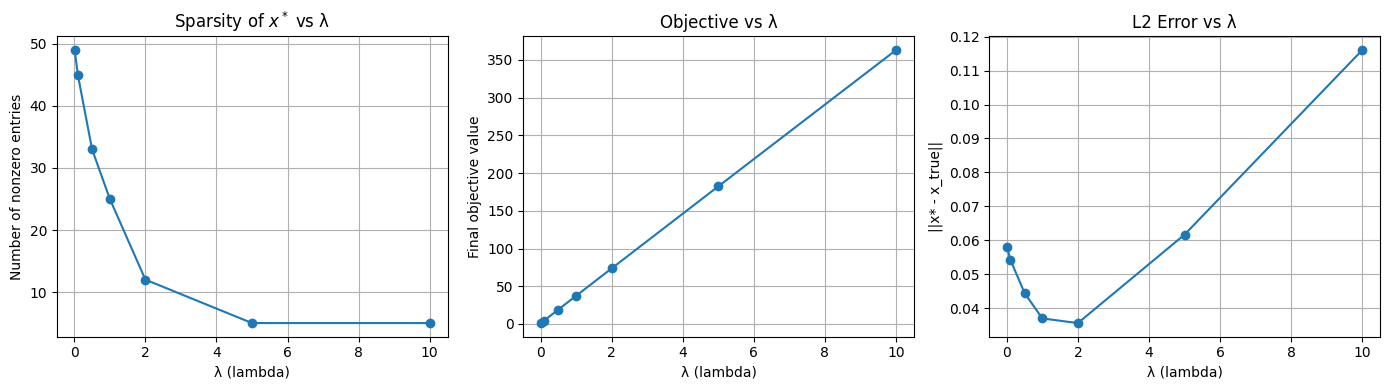

In [7]:
# --- Estimate L = spectral norm of A^T A ---
ATA = A.T @ A
L = np.linalg.norm(ATA, 2)
alpha = 1.0 / L

# --- ISTA Parameters ---
max_iter = 1000
tol = 1e-6

# --- Lambda values to test ---
lambda_list = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

# --- Tracking metrics ---
nonzero_counts = []
objective_values = []
l2_errors = []
all_obj_vals = []  # store full objective curves if needed

for lambda_ in lambda_list:
    x_star, obj_vals = ista_lasso(A, b, lambda_, alpha, max_iter, tol)

    nnz = np.count_nonzero(x_star)
    final_obj = lasso_objective(A, b, x_star, lambda_)
    error_norm = np.linalg.norm(x_star - x_true)

    nonzero_counts.append(nnz)
    objective_values.append(final_obj)
    l2_errors.append(error_norm)
    all_obj_vals.append(obj_vals)

    print(f"λ = {lambda_:>4} → nonzero = {nnz:>2},  objective = {final_obj:.4f},  ||x* - x_true|| = {error_norm:.4f}")

# --- Plot 1: Sparsity vs Lambda ---
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.plot(lambda_list, nonzero_counts, marker='o')
plt.xlabel("λ (lambda)")
plt.ylabel("Number of nonzero entries")
plt.title("Sparsity of $x^*$ vs λ")
plt.grid(True)

# --- Plot 2: Objective vs Lambda ---
plt.subplot(1, 3, 2)
plt.plot(lambda_list, objective_values, marker='o')
plt.xlabel("λ (lambda)")
plt.ylabel("Final objective value")
plt.title("Objective vs λ")
plt.grid(True)

# --- Plot 3: L2 Error vs Lambda ---
plt.subplot(1, 3, 3)
plt.plot(lambda_list, l2_errors, marker='o')
plt.xlabel("λ (lambda)")
plt.ylabel("||x* - x_true||")
plt.title("L2 Error vs λ")
plt.grid(True)

plt.tight_layout()
plt.show()



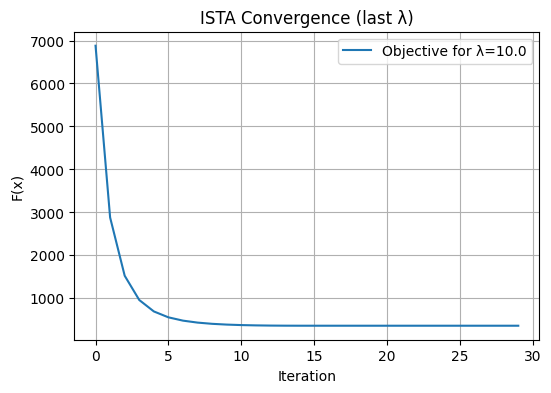

In [8]:
# --- Optional: Plot objective curve for the last lambda ---
plt.figure(figsize=(6,4))
plt.plot(all_obj_vals[-1], label=f"Objective for λ={lambda_list[-1]}")
plt.xlabel("Iteration")
plt.ylabel("F(x)")
plt.title("ISTA Convergence (last λ)")
plt.grid(True)
plt.legend()
plt.show()


---
## **Conclusions and Next Steps**

- ISTA provides a simple method for LASSO: gradient step + soft-thresholding.
- If `lambda_` is larger, the solution becomes sparser.
- Next steps:
  - Implement **FISTA** for faster convergence.
  - Compare ISTA vs FISTA on execution time and iteration count.
  - Use a real-world dataset to observe how LASSO helps with variable selection.


## 8. FISTA Implementation

FISTA (**Fast Iterative Shrinkage-Thresholding Algorithm**) is an accelerated version of ISTA.  
It improves the convergence rate from **O(1/k)** (ISTA) to **O(1/k²)** by adding a **momentum step**.

At each iteration, FISTA uses:
- a **gradient step** at a point $y^k$ (a linear combination of previous iterates),
- followed by a **proximal step** (soft-thresholding),
- and then updates the auxiliary sequence $(t_k)$ and the extrapolated point $y^{k+1}$.

### Update rules:

1. Gradient descent + prox:
$$
x^k = \text{prox}_{\alpha \lambda \|\cdot\|_1}(y^k - \alpha \nabla f(y^k))
$$

2. Acceleration update:
$$
t_{k+1} = \frac{1 + \sqrt{1 + 4t_k^2}}{2}
$$

3. Extrapolation:
$$
y^{k+1} = x^k + \left(\frac{t_k - 1}{t_{k+1}}\right)(x^k - x^{k-1})
$$


In [9]:
def fista_lasso(A, b, lambda_, alpha, max_iter=1000, tol=1e-6):
    """
    FISTA algorithm for solving the LASSO problem:
        min_x 0.5 * ||Ax - b||^2 + lambda * ||x||_1

    Parameters:
        A        : data matrix (m x n)
        b        : target vector (m,)
        lambda_  : regularization parameter
        alpha    : step size (typically 1 / L)
        max_iter : maximum number of iterations
        tol      : stopping tolerance based on x update

    Returns:
        x_new       : final solution
        obj_values  : list of objective values over iterations
    """
    _, n = A.shape
    x_old = np.zeros(n)
    y = np.zeros(n)
    t = 1.0
    obj_values = []

    for k in range(max_iter):
        # Gradient step at y
        grad = grad_f(A, b, y)
        temp = y - alpha * grad

        # Proximal step (soft-thresholding)
        x_new = prox_l1(temp, alpha * lambda_)

        # Save objective value
        obj = lasso_objective(A, b, x_new, lambda_)
        obj_values.append(obj)

        # Stopping condition
        if np.linalg.norm(x_new - x_old) < tol * np.linalg.norm(x_old + 1e-8):
            break

        # Acceleration update
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        y = x_new + ((t - 1) / t_new) * (x_new - x_old)

        # Update for next iteration
        x_old = x_new
        t = t_new

    return x_new, obj_values


In [10]:
# --- Same setup as before ---
ATA = A.T @ A
L = np.linalg.norm(ATA, 2)
alpha = 1.0 / L

max_iter = 1000
tol = 1e-6
lambda_list = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

# --- Tracking results ---
fista_nonzero_counts = []
fista_objective_values = []
fista_l2_errors = []
fista_all_obj_vals = []

for lambda_ in lambda_list:
    x_star_fista, obj_vals_fista = fista_lasso(A, b, lambda_, alpha, max_iter, tol)

    nnz = np.count_nonzero(x_star_fista)
    final_obj = lasso_objective(A, b, x_star_fista, lambda_)
    error_norm = np.linalg.norm(x_star_fista - x_true)

    fista_nonzero_counts.append(nnz)
    fista_objective_values.append(final_obj)
    fista_l2_errors.append(error_norm)
    fista_all_obj_vals.append(obj_vals_fista)

    print(f"[FISTA] λ = {lambda_:>4} → nonzero = {nnz:>2},  objective = {final_obj:.4f},  ||x* - x_true|| = {error_norm:.4f}")


[FISTA] λ = 0.01 → nonzero = 49,  objective = 1.2271,  ||x* - x_true|| = 0.0580
[FISTA] λ =  0.1 → nonzero = 45,  objective = 4.5197,  ||x* - x_true|| = 0.0543
[FISTA] λ =  0.5 → nonzero = 33,  objective = 19.1251,  ||x* - x_true|| = 0.0444
[FISTA] λ =  1.0 → nonzero = 25,  objective = 37.3362,  ||x* - x_true|| = 0.0370
[FISTA] λ =  2.0 → nonzero = 12,  objective = 73.6675,  ||x* - x_true|| = 0.0356
[FISTA] λ =  5.0 → nonzero =  5,  objective = 182.3581,  ||x* - x_true|| = 0.0617
[FISTA] λ = 10.0 → nonzero =  5,  objective = 362.9550,  ||x* - x_true|| = 0.1160


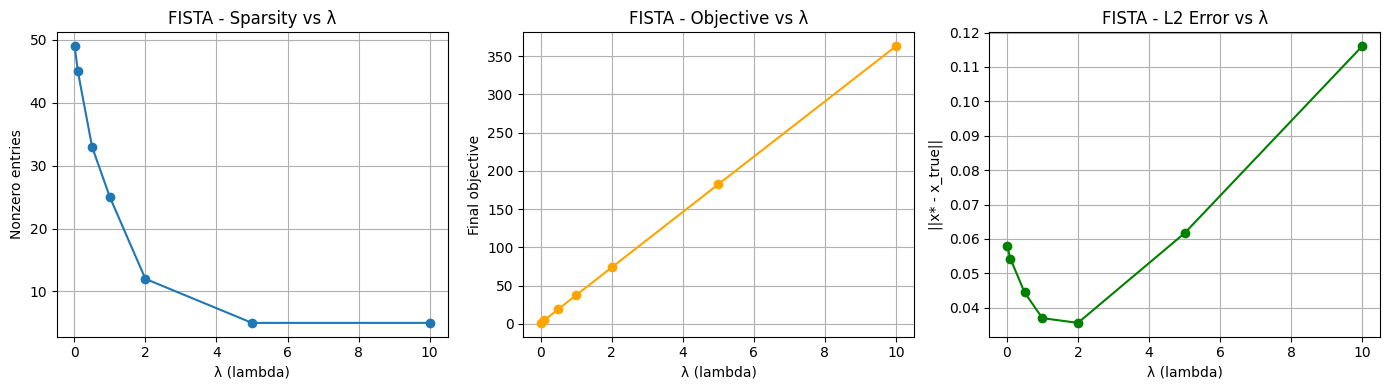

In [11]:
plt.figure(figsize=(14, 4))

# --- Plot 1: Sparsity ---
plt.subplot(1, 3, 1)
plt.plot(lambda_list, fista_nonzero_counts, marker='o', label="FISTA")
plt.xlabel("λ (lambda)")
plt.ylabel("Nonzero entries")
plt.title("FISTA - Sparsity vs λ")
plt.grid(True)

# --- Plot 2: Objective ---
plt.subplot(1, 3, 2)
plt.plot(lambda_list, fista_objective_values, marker='o', label="FISTA", color='orange')
plt.xlabel("λ (lambda)")
plt.ylabel("Final objective")
plt.title("FISTA - Objective vs λ")
plt.grid(True)

# --- Plot 3: L2 Error ---
plt.subplot(1, 3, 3)
plt.plot(lambda_list, fista_l2_errors, marker='o', label="FISTA", color='green')
plt.xlabel("λ (lambda)")
plt.ylabel("||x* - x_true||")
plt.title("FISTA - L2 Error vs λ")
plt.grid(True)

plt.tight_layout()
plt.show()


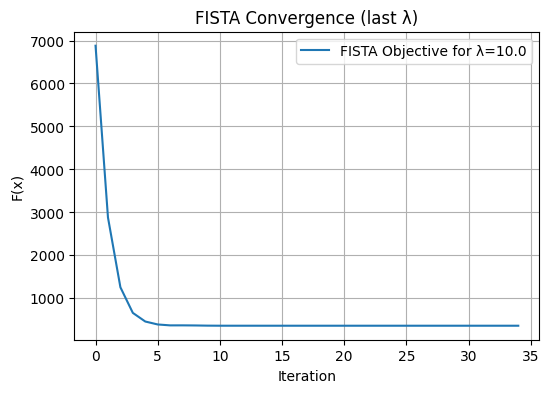

In [12]:
plt.figure(figsize=(6,4))
plt.plot(fista_all_obj_vals[-1], label=f"FISTA Objective for λ={lambda_list[-1]}")
plt.xlabel("Iteration")
plt.ylabel("F(x)")
plt.title("FISTA Convergence (last λ)")
plt.grid(True)
plt.legend()
plt.show()


## 9. ISTA vs FISTA: Convergence Comparison

In this section, we compare the convergence speed of ISTA and FISTA.

We solve the same LASSO problem with the same regularization strength (e.g. $\lambda = 1.0$) using both algorithms.

We then plot the evolution of the objective function $F(x)$ over iterations.

### Expected result:
- FISTA should converge faster than ISTA.
- This reflects the difference in theoretical convergence rates:
  - ISTA: $\mathcal{O}(1/k)$
  - FISTA: $\mathcal{O}(1/k^2)$


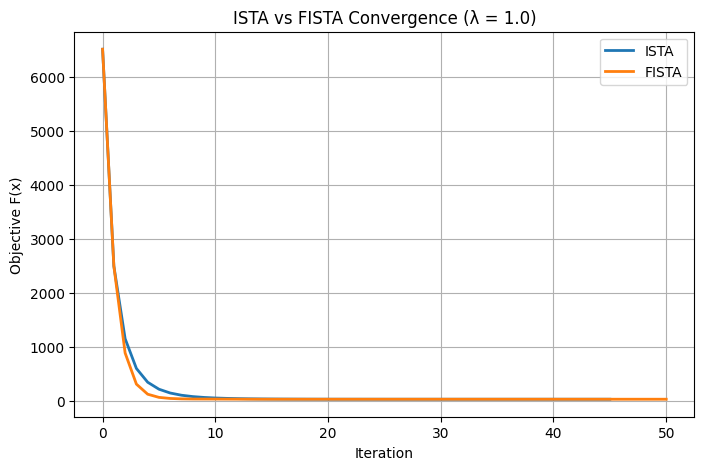

In [13]:
# --- Choose a lambda for comparison ---
lambda_comp = 1.0

# --- Run ISTA ---
x_ista, obj_vals_ista = ista_lasso(A, b, lambda_comp, alpha, max_iter=1000, tol=1e-6)

# --- Run FISTA ---
x_fista, obj_vals_fista = fista_lasso(A, b, lambda_comp, alpha, max_iter=1000, tol=1e-6)

# --- Plot comparison of convergence ---
plt.figure(figsize=(8, 5))
plt.plot(obj_vals_ista, label="ISTA", linewidth=2)
plt.plot(obj_vals_fista, label="FISTA", linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Objective F(x)")
plt.title(f"ISTA vs FISTA Convergence (λ = {lambda_comp})")
plt.legend()
plt.grid(True)
plt.show()



## 10. Comparative Analysis: ISTA vs FISTA

In this section, we compare ISTA and FISTA across multiple values of λ.

We evaluate:
- 🔁 Number of iterations (convergence speed)
- 🧮 Sparsity of the final solution
- 📏 L2 error between the estimated solution and the ground truth

This comparison helps understand not only which algorithm is faster but also which is more accurate and produces sparser solutions.


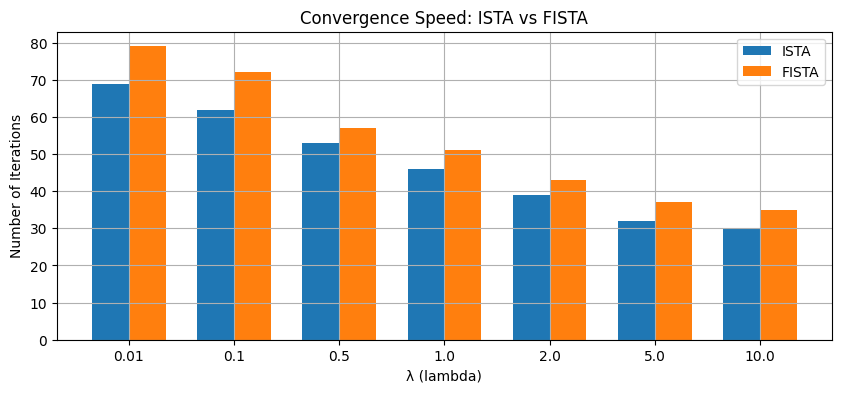

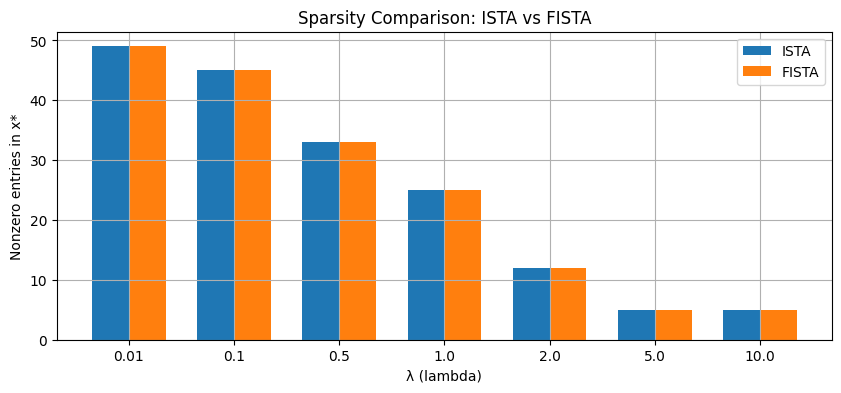

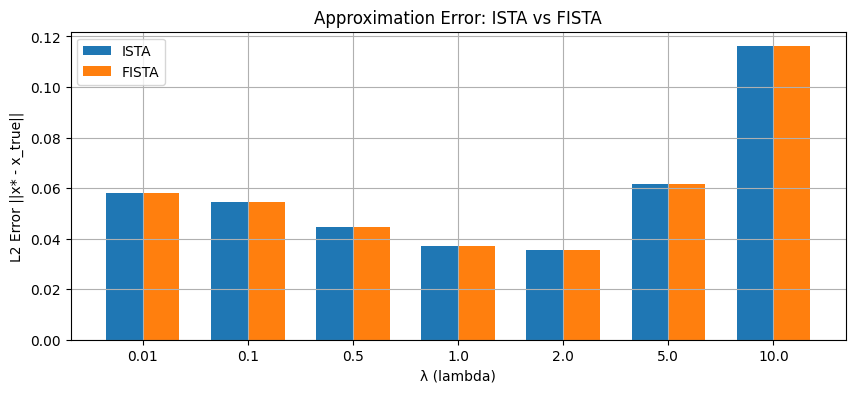

In [14]:

# --- Compute iteration counts for both methods ---
ista_iters = [len(vals) for vals in all_obj_vals]
fista_iters = [len(vals) for vals in fista_all_obj_vals]

x = np.arange(len(lambda_list))  # index for each λ
bar_width = 0.35

# --- Bar Plot: Number of Iterations ---
plt.figure(figsize=(10, 4))
plt.bar(x - bar_width/2, ista_iters, width=bar_width, label='ISTA')
plt.bar(x + bar_width/2, fista_iters, width=bar_width, label='FISTA')
plt.xticks(x, lambda_list)
plt.xlabel("λ (lambda)")
plt.ylabel("Number of Iterations")
plt.title("Convergence Speed: ISTA vs FISTA")
plt.legend()
plt.grid(True)
plt.show()

# --- Bar Plot: Sparsity (Non-zero Coefficients) ---
plt.figure(figsize=(10, 4))
plt.bar(x - bar_width/2, nonzero_counts, width=bar_width, label='ISTA')
plt.bar(x + bar_width/2, fista_nonzero_counts, width=bar_width, label='FISTA')
plt.xticks(x, lambda_list)
plt.xlabel("λ (lambda)")
plt.ylabel("Nonzero entries in x*")
plt.title("Sparsity Comparison: ISTA vs FISTA")
plt.legend()
plt.grid(True)
plt.show()

# --- Bar Plot: L2 Error ---
plt.figure(figsize=(10, 4))
plt.bar(x - bar_width/2, l2_errors, width=bar_width, label='ISTA')
plt.bar(x + bar_width/2, fista_l2_errors, width=bar_width, label='FISTA')
plt.xticks(x, lambda_list)
plt.xlabel("λ (lambda)")
plt.ylabel("L2 Error ||x* - x_true||")
plt.title("Approximation Error: ISTA vs FISTA")
plt.legend()
plt.grid(True)
plt.show()


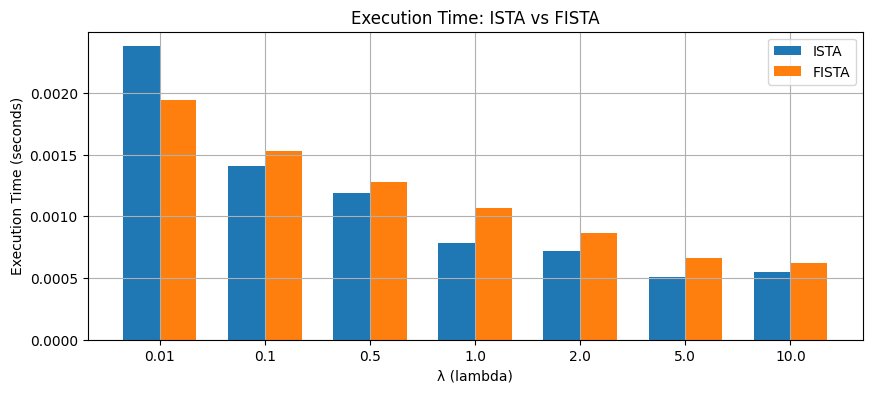

In [15]:

import time

ista_times = []
fista_times = []

for lambda_ in lambda_list:
    # Time ISTA
    start_ista = time.perf_counter()
    _, _ = ista_lasso(A, b, lambda_, alpha, max_iter, tol)
    end_ista = time.perf_counter()
    ista_times.append(end_ista - start_ista)

    # Time FISTA
    start_fista = time.perf_counter()
    _, _ = fista_lasso(A, b, lambda_, alpha, max_iter, tol)
    end_fista = time.perf_counter()
    fista_times.append(end_fista - start_fista)

# Plot execution time comparison
plt.figure(figsize=(10, 4))
plt.bar(x - bar_width/2, ista_times, width=bar_width, label='ISTA')
plt.bar(x + bar_width/2, fista_times, width=bar_width, label='FISTA')
plt.xticks(x, lambda_list)
plt.xlabel("λ (lambda)")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time: ISTA vs FISTA")
plt.legend()
plt.grid(True)
plt.show()
